# Лабораторная работа № 2

## Киреев Андрей ИУ5-63Б

# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

## Цель лабораторной работы: изучение способов предварительной обработки данных для дальнейшего формирования моделей.

## Задание:


- Выбрать набор данных (датасет), содержащий категориальные признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.)
- Для выбранного датасета (датасетов) на основе материалов лекции решить следующие задачи:
  - обработку пропусков в данных;
  - кодирование категориальных признаков;
  - масштабирование данных.

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, Normalizer
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data-130k-v2.csv

In [2]:
data = pd.read_csv('winemag-data-130k-v2.csv', sep=",")

In [3]:
data.shape

(129971, 14)

In [4]:
# Типы колонок
data.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [5]:
# Проверим, есть ли пропущенные значения
data.isnull().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Обработка пропусков в данных

In [8]:
(data.shape, data.shape)

((129971, 14), (129971, 14))

In [11]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((129971, 14), (129971, 5))

In [12]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((129971, 14), (22387, 14))

In [13]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка price. Тип данных float64. Количество пустых значений 8996, 6.92%.


In [14]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,price
0,NaN
1,15.0
2,14.0
3,13.0
4,65.0
...,...
129966,28.0
129967,75.0
129968,30.0
129969,32.0


### Гистограмма по признакам

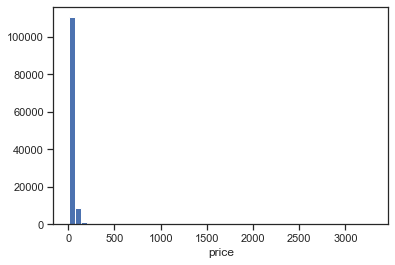

In [22]:
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [15]:
data_num_Price = data_num[['price']]
data_num_Price.head()

,price
0,NaN
1,15.0
2,14.0
3,13.0
4,65.0


In [16]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_Price)
mask_missing_values_only

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [17]:
strategies=['mean', 'median', 'most_frequent']

In [18]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_Price)
    return data_num_imp[mask_missing_values_only]

In [19]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([35.36338913, 35.36338913, 35.36338913, ..., 35.36338913,
        35.36338913, 35.36338913]))

In [20]:
strategies[1], test_num_impute(strategies[1])

('median', array([25., 25., 25., ..., 25., 25., 25.]))

In [21]:
strategies[2], test_num_impute(strategies[2])

('most_frequent', array([20., 20., 20., ..., 20., 20., 20.]))

In [23]:
data[['price']].describe()

,price
count,120975.000000
mean,35.363389
std,41.022218
min,4.000000
25%,17.000000
50%,25.000000
75%,42.000000
max,3300.000000


### Обработка пропусков в категориальных данных

In [24]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка country. Тип данных object. Количество пустых значений 63, 0.05%.
Колонка designation. Тип данных object. Количество пустых значений 37465, 28.83%.
Колонка province. Тип данных object. Количество пустых значений 63, 0.05%.
Колонка region_1. Тип данных object. Количество пустых значений 21247, 16.35%.
Колонка region_2. Тип данных object. Количество пустых значений 79460, 61.14%.
Колонка taster_name. Тип данных object. Количество пустых значений 26244, 20.19%.
Колонка taster_twitter_handle. Тип данных object. Количество пустых значений 31213, 24.02%.
Колонка variety. Тип данных object. Количество пустых значений 1, 0.0%.


In [25]:
cat_temp_data = data[['country']]
cat_temp_data.head()

,country
0,Italy
1,Portugal
2,US
3,US
4,US


In [26]:
cat_temp_data['country'].unique()

array(['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', nan, 'Turkey', 'Czech Republic', 'Slovenia',
       'Luxembourg', 'Croatia', 'Georgia', 'Uruguay', 'England',
       'Lebanon', 'Serbia', 'Brazil', 'Moldova', 'Morocco', 'Peru',
       'India', 'Bulgaria', 'Cyprus', 'Armenia', 'Switzerland',
       'Bosnia and Herzegovina', 'Ukraine', 'Slovakia', 'Macedonia',
       'China', 'Egypt'], dtype=object)

In [27]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['Italy'],
       ['Portugal'],
       ['US'],
       ...,
       ['France'],
       ['France'],
       ['France']], dtype=object)

In [28]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['Argentina', 'Armenia', 'Australia', 'Austria',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'China', 'Croatia', 'Cyprus', 'Czech Republic', 'Egypt', 'England',
       'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India',
       'Israel', 'Italy', 'Lebanon', 'Luxembourg', 'Macedonia', 'Mexico',
       'Moldova', 'Morocco', 'New Zealand', 'Peru', 'Portugal', 'Romania',
       'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'Spain',
       'Switzerland', 'Turkey', 'US', 'Ukraine', 'Uruguay'], dtype=object)

In [30]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['Italy'],
       ['Portugal'],
       ['US'],
       ...,
       ['France'],
       ['France'],
       ['France']], dtype=object)

In [31]:
np.unique(data_imp3)

array(['Argentina', 'Armenia', 'Australia', 'Austria',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'China', 'Croatia', 'Cyprus', 'Czech Republic', 'Egypt', 'England',
       'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India',
       'Israel', 'Italy', 'Lebanon', 'Luxembourg', 'Macedonia', 'Mexico',
       'Moldova', 'Morocco', 'NA', 'New Zealand', 'Peru', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'South Africa',
       'Spain', 'Switzerland', 'Turkey', 'US', 'Ukraine', 'Uruguay'],
      dtype=object)

### Преобразование категориальных признаков в числовые

In [32]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,Italy
1,Portugal
2,US
3,US
4,US
...,...
129966,Germany
129967,US
129968,France
129969,France


In [34]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [35]:
cat_enc['c1'].unique()

array(['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', 'Turkey', 'Czech Republic', 'Slovenia', 'Luxembourg',
       'Croatia', 'Georgia', 'Uruguay', 'England', 'Lebanon', 'Serbia',
       'Brazil', 'Moldova', 'Morocco', 'Peru', 'India', 'Bulgaria',
       'Cyprus', 'Armenia', 'Switzerland', 'Bosnia and Herzegovina',
       'Ukraine', 'Slovakia', 'Macedonia', 'China', 'Egypt'], dtype=object)

In [36]:
np.unique(cat_enc_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

In [37]:
le.inverse_transform([0, 1, 2, 3])

array(['Argentina', 'Armenia', 'Australia', 'Austria'], dtype=object)

In [38]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Кодирование категорий наборами бинарных значений

In [43]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [44]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],


In [45]:
cat_enc.head(10)

,c1
0,Italy
1,Portugal
2,US
3,US
4,US
5,Spain
6,Italy
7,France
8,Germany
9,France


### Масштабирование данных

In [48]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### MinMax Масштабирование

In [54]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['points']])

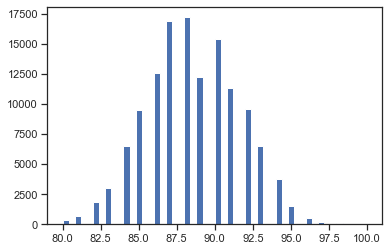

In [55]:
plt.hist(data['points'], 50)
plt.show()

### Масштабирование данных на основе Z-оценки

In [57]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['points']])

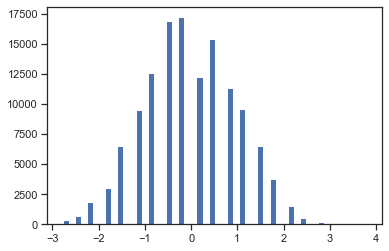

In [58]:
plt.hist(sc2_data, 50)
plt.show()